In [1]:
from pyspark.sql import SparkSession 

In [2]:
spark = SparkSession.builder.appName("Prepare data for modeling").master("local[4]").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/25 19:01:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# creating a dataframe
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
], schema=['id', 'weight', 'height', 'age', 'gender'])

In [4]:
# checking for duplicates
print(f"Count of rows: {df.count()}")
print(f"Count of distinct rows: {df.distinct().count()}")

Count of rows: 7


Count of distinct rows: 6


In [5]:
df = df.dropDuplicates() # drops the exact copies of the rows
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 133.2|   5.7| 54|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [6]:
# check whether there are any duplicates in the data irrespective of ID
print(f"Count of ids: {df.count()}")
print(f"Count of distince ids: {df.select([c for c in df.columns if c != 'id']).distinct().count()}")

Count of ids: 6
Count of distince ids: 5


In [7]:
# calculating the total and distince number of IDs in one step we can use the agg method
import pyspark.sql.functions as fn

df.agg(
    fn.count("id").alias("count"),
    fn.countDistinct("id").alias("distinct")
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    6|       5|
+-----+--------+



In [8]:
# giving a unique id to each row
df.withColumn("new_id", fn.monotonically_increasing_id()).show()

+---+------+------+---+------+------+
| id|weight|height|age|gender|new_id|
+---+------+------+---+------+------+
|  1| 144.5|   5.9| 33|     M|     0|
|  2| 167.2|   5.4| 45|     M|     1|
|  3| 124.1|   5.2| 23|     F|     2|
|  5| 133.2|   5.7| 54|     F|     3|
|  4| 144.5|   5.9| 33|     M|     4|
|  5| 129.2|   5.3| 42|     M|     5|
+---+------+------+---+------+------+



In [9]:
# handling missing observations
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [10]:
# to find the number of missing observations per row we can use the snippet
df_miss.rdd.map(lambda row: (row["id"], sum([c == None for c in row]))).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

In [11]:
# to see what values are missing
df_miss.where("id == 3").show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



In [12]:
# calculating the percentage of missing values in each column
df_miss.agg(*[( 1- (fn.count(c)/fn.count("*"))).alias(c+ "_missing") for c in df_miss.columns]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



In [13]:
# we will drop the "income" feature because it has many missing values
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != "income"])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [14]:
# to drop the observations with a certain threshold we can use `.dropna()`
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [15]:
# for imputation with mean, median or other calculated value we need to first calculate the values and then create a dict with all such values
# and then pass it to `.fillna()` method.
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != "id"]
    ).toPandas().to_dict("records")[0]

means['gender'] = 'missing'

means

{'weight': 140.28333333333333,
 'height': 5.471428571428572,
 'age': 40.4,
 'gender': 'missing'}

In [16]:
df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



In [17]:
# Treating outliers
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

In [18]:
# first we need to calculate the lower and upper cutoff points for each feature
cols = ["weight", "height", "age"]
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

In [19]:
# limiting the values to fall n the required range
outliers = df_outliers.select(*["id"] + [((df_outliers[c] < bounds[c][0]) | (df_outliers[c] > bounds[c][1])).alias(c + "_o") for c in cols])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



In [20]:
# we have two outliers in the `weight` and two in `age` feature
df_outliers = df_outliers.join(outliers, on="id")
df_outliers.filter("weight_o").select("id", "weight").show()
df_outliers.filter("age_o").select("id", "age").show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



In [21]:
# descriptive statistics
import pyspark.sql.types as typ
from pyspark import SparkContext

In [22]:
sc = SparkContext.getOrCreate()

In [23]:
fraud = sc.textFile("ccFraud.csv.gz")
header = fraud.first()

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(",")])

In [24]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(",")
    ]
]

schema = typ.StructType(fields)

In [30]:
fraud_df = spark.createDataFrame(fraud, schema)
fraud_df.show(5)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
|     2|     2|    2|         1|      0|       9|           0|        18|        0|
|     3|     2|    2|         1|      0|      27|           9|        16|        0|
|     4|     1|   15|         1|      0|      12|           0|         5|        0|
|     5|     1|   46|         1|      0|      11|          16|         7|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 5 rows



In [31]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [32]:
numerical = ["balance", "numTrans", "numIntlTrans"]

In [33]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [34]:
fraud_df.agg({"balance": "skewness"}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



In [36]:
# Correlations
fraud_df.corr("balance", "numTrans")

0.00044523140172659576

In [37]:
# in order to create a correlations matrix we need to create a script
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)

corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

In [43]:
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [45]:
hists = fraud_df.select("balance").rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 1.0, 'Histogram of balance')

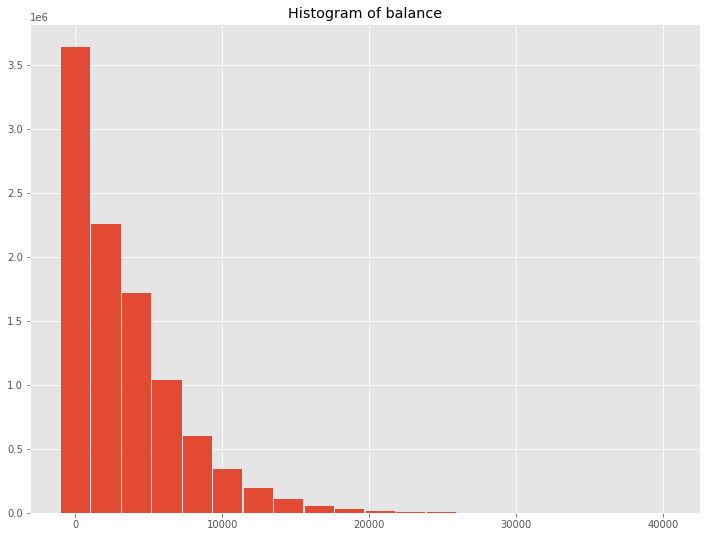

In [46]:
data = {
    "bins": hists[0][:-1],
    "freq": hists[1]
}

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data["bins"], data["freq"], width=2000)
ax.set_title("Histogram of balance")